In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

from scipy import stats
from scipy.stats import norm, skew #for some statistics

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

all_data = pd.concat([train, test], axis=0, sort=False)
y_train = train['SalePrice']
test_id = test['Id']

print('Lots of NaN that will need dealing with in test and training CSVs')
all_data.head(3)

Lots of NaN that will need dealing with in test and training CSVs


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0


In [3]:
print('In this case we should check for duplicate data.')

# Create a set (set is like a dictionary as no duplicate keys are added on creation) 
# Therefore if the length of the set is the same as the total there are no duplicates
idsUnique = len(set(all_data.Id))
idsTotal = all_data.shape[0]
idsdupe = idsTotal - idsUnique
print('Number of duplicates: ' + str(idsdupe))


In this case we should check for duplicate data.
Number of duplicates: 0


SharePrice is our dependant variable so we draw a graph to see its...... positively skewed.


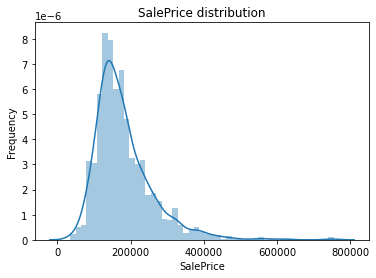

<Figure size 432x288 with 0 Axes>

In [4]:
print('SharePrice is our dependant variable so we draw a graph to see its...... positively skewed.')

sns.distplot(train['SalePrice']);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
plt.show()

Sorting SharePrice Skew...


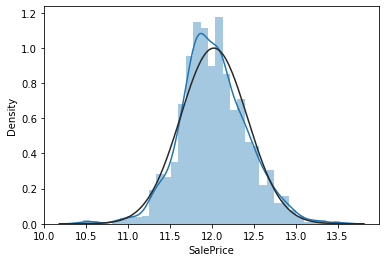

In [5]:
print('Sorting SharePrice Skew...')
all_data['SalePrice'] = np.log1p(all_data['SalePrice'])
sns.distplot(all_data['SalePrice'], fit=norm);

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')


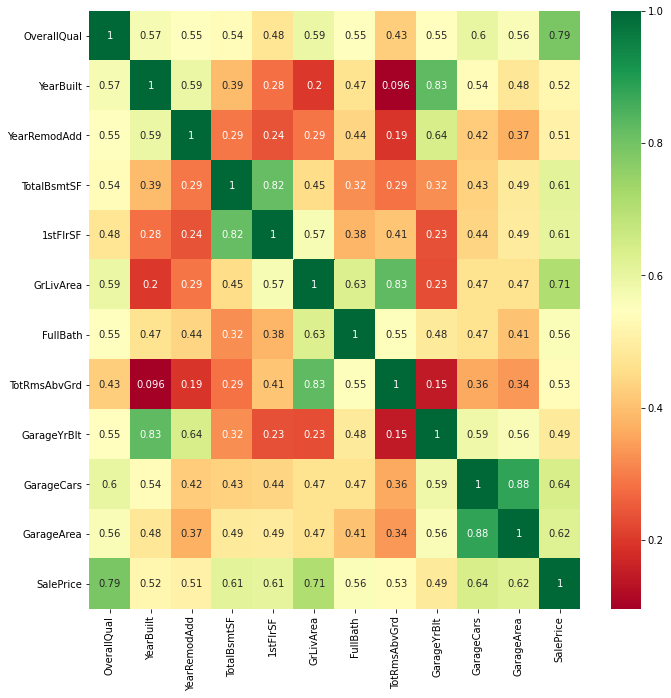

In [6]:
# VISUALISATION - great way of visualising and causality
corrmat = all_data.corr() # Create Corrolation

# Creates an index of the list of column headers greater than 0.5
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5] 
print(top_corr_features)

# Creates the plot
plt.figure(figsize=(len(top_corr_features)-1,len(top_corr_features)-1)) # 0 based to 11 x 11

# Creates the heatmap from the training set columns in the indexed list
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We can see from the heatmap and the graph below OverallQual is highly correlated to SalePrice
Other observations: 
 - OverallQual, GrLivArea and TotalBsmtSF are strongly correlated with SalePrice.
 - GarageCars and GarageArea are also but these are likely causal so we only need one.
 - TotalBsmtSF and 1stFlrSF are likely twins due to them being on top of each other.
 - TotRmsAbvGrd and GrLivArea, likely twins.


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

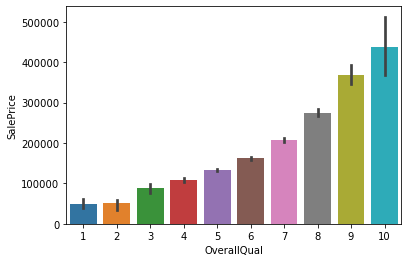

In [7]:
print('We can see from the heatmap and the graph below OverallQual is highly correlated to SalePrice')
print('Other observations: ')
print(' - OverallQual, GrLivArea and TotalBsmtSF are strongly correlated with SalePrice.')
print(' - GarageCars and GarageArea are also but these are likely causal so we only need one.')
print(' - TotalBsmtSF and 1stFlrSF are likely twins due to them being on top of each other.')
print(' - TotRmsAbvGrd and GrLivArea, likely twins.')
sns.barplot(train.OverallQual,train.SalePrice)

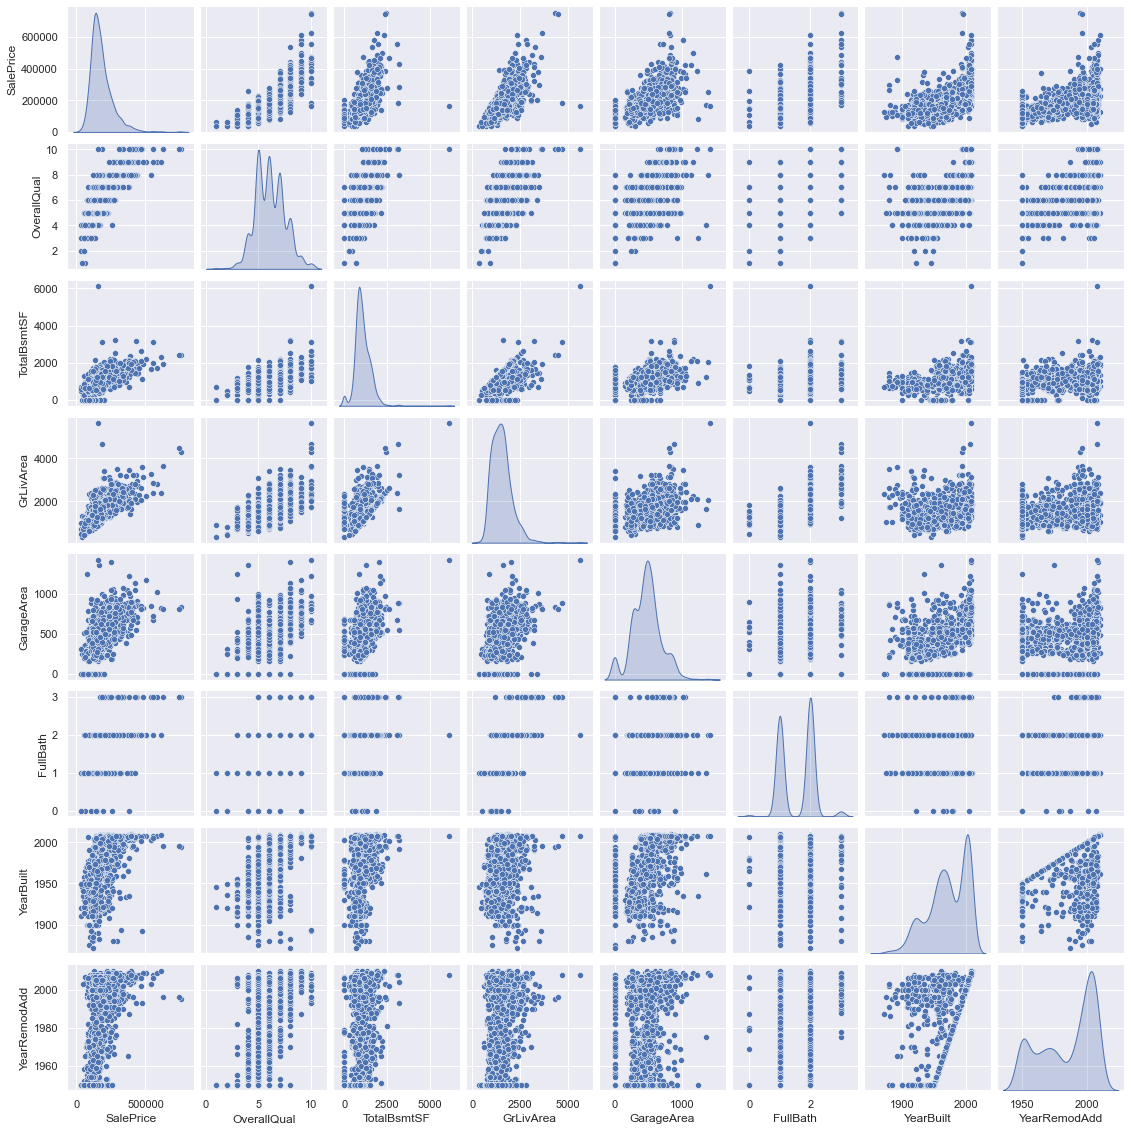

In [8]:
sns.set()
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

In [9]:
print('Observations: ')
print(' - TotalBsmtSF and GrLiveArea has a clear line which indicates no houses have larger basements than ground floors which makes sense.')
print(' - SalePrice and YearBuilt is almost exponential, as the houses get newer they get more expensive.')

Observations: 
 - TotalBsmtSF and GrLiveArea has a clear line which indicates no houses have larger basements than ground floors which makes sense.
 - SalePrice and YearBuilt is almost exponential, as the houses get newer they get more expensive.


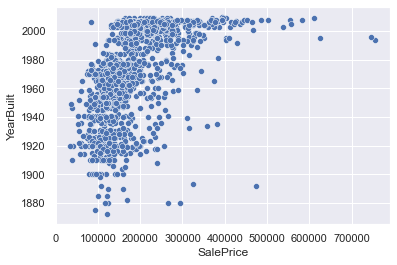

In [10]:
# Taking a larger look at last observation
new_df = pd.DataFrame({'SalePrice': train.SalePrice,'YearBuilt': train.YearBuilt})
sns.set_theme(color_codes=True)
ax = sns.scatterplot(x="SalePrice", y="YearBuilt", data=new_df)

In [11]:
# Find totals of rows in features with missing values
Total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [12]:
# Drop columns that are not needed
print('No duplicates so drop Id column as not needed.')
all_data = all_data.drop(['Id'], axis=1)

No duplicates so drop Id column as not needed.


In [13]:
# Features with high % of missing values are not important features
print('No values with nulls > 5 have a strong correlation, so drop them.')
all_data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
print(all_data.isnull().sum().max())

No values with nulls > 5 have a strong correlation, so drop them.
4


In [14]:
total = all_data.isnull().sum().sort_values(ascending=False)
total.head(25)

MSZoning         4
BsmtHalfBath     2
BsmtFullBath     2
Functional       2
Utilities        2
Exterior1st      1
KitchenQual      1
GarageCars       1
GarageArea       1
BsmtFinSF1       1
Exterior2nd      1
SaleType         1
TotalBsmtSF      1
BsmtUnfSF        1
BsmtFinSF2       1
Electrical       1
YearBuilt        0
ExterQual        0
RoofMatl         0
RoofStyle        0
YearRemodAdd     0
SaleCondition    0
OverallCond      0
OverallQual      0
ExterCond        0
dtype: int64

In [15]:
# MISSING DATA - FIND Numeric
numeric_features = all_data.select_dtypes(include=[np.number])
numeric_missing = numeric_features.isnull().sum().sort_values(ascending=False)
numeric_missing = numeric_missing[numeric_missing>0]
print(numeric_missing)

BsmtHalfBath    2
BsmtFullBath    2
BsmtFinSF1      1
TotalBsmtSF     1
BsmtUnfSF       1
GarageCars      1
BsmtFinSF2      1
GarageArea      1
dtype: int64


In [16]:
# MISSING DATA - HANDLE Numeric

# create a table of just numeric data
print("NAs for numerical features in train : " + str(all_data.select_dtypes(include=[np.number]).isnull().values.sum()))

# replace with median as positively skewed
for feature in numeric_features:
    all_data[feature] = all_data[feature].fillna(0)
print("Remaining NAs for numerical features in train : " + str(all_data.select_dtypes(include=[np.number]).isnull().values.sum()))


NAs for numerical features in train : 10
Remaining NAs for numerical features in train : 0


In [17]:
# MISSING DATA - FIND Categoric
categoric_features = all_data.select_dtypes(include=[object])
categoric_features_sums = categoric_features.isnull().sum().sort_values(ascending=False)
categoric_features_sums = categoric_features_sums[categoric_features_sums>0]
print(categoric_features_sums)

MSZoning       4
Functional     2
Utilities      2
KitchenQual    1
Electrical     1
Exterior2nd    1
Exterior1st    1
SaleType       1
dtype: int64


In [18]:
# MISSING DATA - HANDLE Categoric (replace with the mode)
print("NAs for numerical features in train : " + str(all_data.select_dtypes(include=[object]).isnull().values.sum()))

for col in categoric_features.columns:
    all_data[col].fillna(all_data[col].mode()[0],inplace= True)

# Check if missing values are imputed successfully
categoric_features_filled = all_data.select_dtypes(include=[object]).isnull().sum().sort_values(ascending=False)
print(categoric_features_filled)

NAs for numerical features in train : 13
SaleCondition    0
SaleType         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
ExterCond        0
Foundation       0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
PavedDrive       0
MSZoning         0
dtype: int64


In [19]:
# FINAL CHECK FOR MISSING VALUES
all_data.isnull().sum().max()

0

In [20]:
# Fix the Skewness in the other fatures
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew



MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [21]:
# HANDLE NUMERIC SKEW
for feature in high_skew.index:
    all_data[feature] = np.log1p(all_data[feature])

# Test
numeric_feats_unskewed = all_data.dtypes[all_data.dtypes != 'object'].index
numeric_feats_unskewed = all_data[numeric_feats_unskewed].apply(lambda x: skew(x)).sort_values(ascending=False)
print(numeric_feats_unskewed)

PoolArea         14.998335
3SsnPorch         8.825256
LowQualFinSF      8.557690
MiscVal           5.213984
BsmtHalfBath      3.774762
KitchenAbvGr      3.520351
ScreenPorch       2.945905
BsmtFinSF2        2.462483
EnclosedPorch     1.961081
HalfBath          0.580692
BsmtFullBath      0.425167
BedroomAbvGr      0.326324
2ndFlrSF          0.305049
MSSubClass        0.245157
GarageArea        0.239257
Fireplaces        0.237587
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
WoodDeckSF        0.158033
YrSold            0.132399
1stFlrSF          0.064828
TotRmsAbvGrd      0.035107
GrLivArea         0.013188
OpenPorchSF      -0.041797
GarageCars       -0.219581
YearRemodAdd     -0.451020
LotArea          -0.504751
BsmtFinSF1       -0.616632
YearBuilt        -0.626215
OverallCond      -0.746183
BsmtUnfSF        -2.155206
TotalBsmtSF      -4.956294
dtype: float64


In [22]:
# Combining area features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [25]:
# Convert Categorical data to numeric
categoric_columns = all_data.select_dtypes(include=[object]).columns

all_data = pd.get_dummies(all_data[categoric_columns])

In [26]:
# SPLIT THE DATA INTO TRAIN AND TEST
x_train =all_data[:len(y_train)]
x_test = all_data[len(y_train):]

x_test.shape , x_train.shape

((1459, 187), (1460, 187))

In [27]:
# LINEAR REGRESSION MODEL
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
x_train = my_imputer.fit_transform(x_train)
x_test = my_imputer.fit_transform(x_test)
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)

In [29]:
print(round(lr.score(x_train, y_train)*100,2))

79.61


In [30]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(x_train, y_train)
y_pred = forest_model.predict(x_test)
print(round(forest_model.score(x_train, y_train)*100,2))

94.41
